In [1]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-efu35vks
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-efu35vks
  Resolved https://github.com/facebookresearch/detectron2.git to commit 0df2d73d0013db7de629602c23cc120219b4f2b8
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0
torch:  2.1 ; cuda:  2.1.2
detectron2: 0.6


In [3]:
import os
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor, launch
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_train_loader, build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

In [4]:
# Setup detectron2 logger
setup_logger()

# Register COCO datasets
data_path = "/kaggle/input/coco-2017-dataset/coco2017/train2017"
train_ann_file = "/kaggle/input/semis-od-coco-10/instances_train2017_labeled.json"
val_ann_file = "/kaggle/input/semis-od-coco-10/instances_val2017.json"

register_coco_instances("coco_train", {}, train_ann_file, data_path)
register_coco_instances("coco_val", {}, val_ann_file, data_path)

In [5]:
#/kaggle/input/coco-2017-dataset/coco2017/train2017/000000461973.jpg

In [6]:
# Define configuration for the model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = ("coco_train",)
cfg.DATASETS.TEST = ("coco_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.SOLVER.IMS_PER_BATCH = 8
#cfg.SOLVER.BASE_LR = 0.00025
# # Calculate iterations per epoch
# iterations_per_epoch = total_images // batch_size
# We have 2735 train images

# # Calculate total iterations
# total_iterations = iterations_per_epoch * epochs
cfg.SOLVER.MAX_ITER = 4100  
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8  # Number of classes i

cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_1x.yaml")
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Create trainer and start training
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/05 21:56:09 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

R-50.pkl: 102MB [00:00, 125MB/s]                            


[06/05 21:56:10 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[06/05 21:56:11 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 54
[06/05 21:56:11 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/05 21:56:50 d2.utils.events]:  eta: 2:02:00  iter: 19  total_loss: 1.181  loss_cls: 0.3696  loss_box_reg: 0.04263  loss_rpn_cls: 0.6596  loss_rpn_loc: 0.07118    time: 1.8300  last_time: 2.0290  data_time: 0.0547  last_data_time: 0.0822   lr: 0.00039962  max_mem: 11350M


2024-06-05 21:56:52.813592: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 21:56:52.813689: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 21:56:52.944789: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[06/05 21:57:39 d2.utils.events]:  eta: 2:06:39  iter: 39  total_loss: 1.022  loss_cls: 0.485  loss_box_reg: 0.09911  loss_rpn_cls: 0.3361  loss_rpn_loc: 0.0724    time: 1.8600  last_time: 1.7444  data_time: 0.0450  last_data_time: 0.0080   lr: 0.00079922  max_mem: 11350M
[06/05 21:58:18 d2.utils.events]:  eta: 2:09:25  iter: 59  total_loss: 0.9494  loss_cls: 0.4303  loss_box_reg: 0.2407  loss_rpn_cls: 0.1869  loss_rpn_loc: 0.05738    time: 1.9012  last_time: 1.8351  data_time: 0.0483  last_data_time: 0.1009   lr: 0.0011988  max_mem: 11417M
[06/05 21:58:59 d2.utils.events]:  eta: 2:10:24  iter: 79  total_loss: 1.015  loss_cls: 0.4726  loss_box_reg: 0.3447  loss_rpn_cls: 0.1276  loss_rpn_loc: 0.05714    time: 1.9381  last_time: 1.8313  data_time: 0.0427  last_data_time: 0.0661   lr: 0.0015984  max_mem: 11417M
[06/05 21:59:40 d2.utils.events]:  eta: 2:11:23  iter: 99  total_loss: 0.8615  loss_cls: 0.3846  loss_box_reg: 0.2604  loss_rpn_cls: 0.1399  loss_rpn_loc: 0.06068    time: 1.9533  

In [7]:
# Create predictor for evaluation
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75
predictor = DefaultPredictor(cfg)

# Evaluate the model on validation set
evaluator = COCOEvaluator("coco_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "coco_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[06/06 00:11:59 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
[06/06 00:11:59 d2.data.datasets.coco]: Loaded 1232 images in COCO format from /kaggle/input/semis-od-coco-10/instances_val2017.json
[06/06 00:11:59 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/06 00:11:59 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/06 00:11:59 d2.data.common]: Serializing 1232 elements to byte tensors and concatenating them all ...
[06/06 00:11:59 d2.data.common]: Serialized dataset takes 0.51 MiB
[06/06 00:11:59 d2.evaluation.evaluator]: Start inference on 1232 batches
[06/06 00:12:01 d2.evaluation.evaluator]: Inference done 11/1232. Dataloading: 0.0013 s/iter. Inference: 0.1176 s/iter. Eval: 0.0002 s/iter. Total: 0.1192 s/iter. ETA=0:02:25
[06/06 00:12:06 d2.evaluation

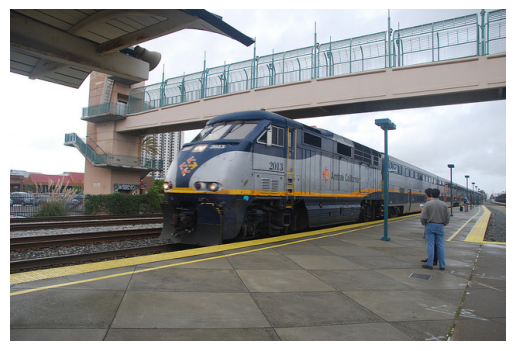

In [8]:
import cv2
import matplotlib.pyplot as plt

im = cv2.imread("/kaggle/input/coco-2017-dataset/coco2017/train2017/000000461973.jpg")
def show_image(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()
# Example usage
show_image(im)

In [9]:
# cfg = get_cfg()
#cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))
#cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model

#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
outputs = predictor(im)

In [10]:
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([3, 5], device='cuda:0')
Boxes(tensor([[  8.8603,   0.0000, 217.7711, 125.0695],
        [173.9056, 104.7086, 613.8829, 295.7137]], device='cuda:0'))


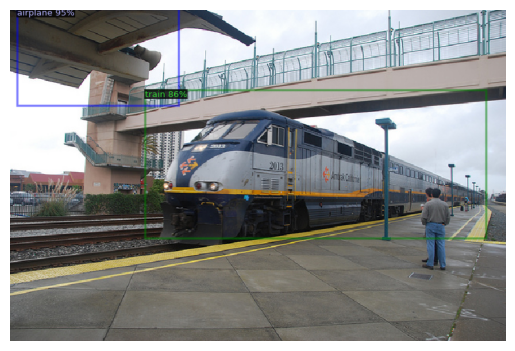

In [11]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
show_image(out.get_image()[:, :, ::-1])